# Sentiment Analysis for Mental Health

Author: Tom Cohen

## 1. Project Overview
This project aims to build and evaluate the use of deep learning models for classifying text data into different mental health-related sentiments. The goal is to develop a robust multiclass text classification model capable of distinguishing between various emotional states such as depression and anxiety, which could have significant applications in mental health monitoring and support systems.

As part of this project we will compare the performance of a baseline logistic regression model with a a Deep Learning solution: a Gated Recurrent Unit (GRU) network. It's a type of Recurrent Neural Network (RNN) well-suited for sequential data like text.

### Dataset Description
* **Source**: Sarkar, S. (2024). *Sentiment Analysis for Mental Health* [Data set](https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health). Kaggle.
* **License**: Database Contents License (DbCL) v1.0  
* **Collection method**: Aggregation of existing datasets, sourced from social media and manually labelled.
* **Size**: 53 043 rows × 3 columns (ID, Statement, Status) ≈ 12 MB.
* **Data Features:
  * Statement: This column contains the textual data (the post). The data type is object (string).
  * Status: This column represents the mental health associated sentiment of the text. It is a categorical feature with the following classes:
    * 0: "Normal"
    * 1: "Depression"
    * 2: "Anxiety"
    * 3: "Suicidal"
    * 4: "Bipolar"
    * 5: "Stress"
    * 6: "Personality Disorder" 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Dropout, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras
import re
import nltk
from nltk.corpus import stopwords
import random
import warnings
warnings.filterwarnings('ignore')

2025-06-13 15:15:37.737795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749827737.949610      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749827738.008853      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set seeds for reproducibility
SEED = 26
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Load the data
df = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")
print(df.shape)
df.head()

(53043, 3)


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


## 2.  Exploratory Data Analysis (EDA)
We begin by inspecting the basic characteristics of the dataset, followed by visualisations of class distribution and text‑length statistics.

In [3]:
# Basic summary
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


None

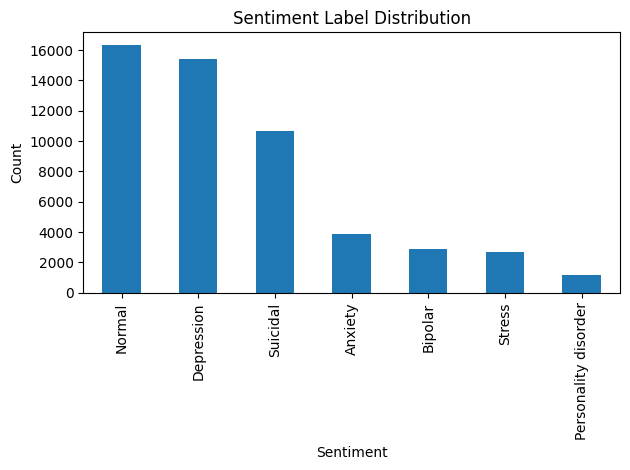

In [4]:
# Class distribution
plt.figure()
df['status'].value_counts().plot(kind='bar')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

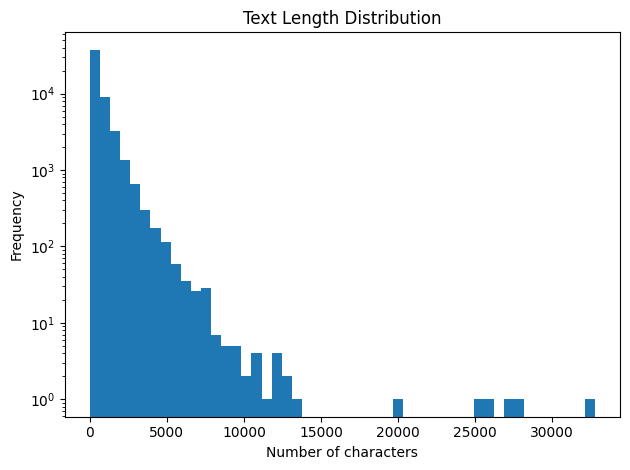

In [5]:
# Text length distribution
df['text_len'] = df['statement'].str.len()
plt.figure()
plt.hist(df['text_len'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [6]:
print("Number of Missing Statements: ", df['statement'].isnull().sum())
print("Number of Missing Statuses: ", df['status'].isnull().sum())

Number of Missing Statements:  362
Number of Missing Statuses:  0


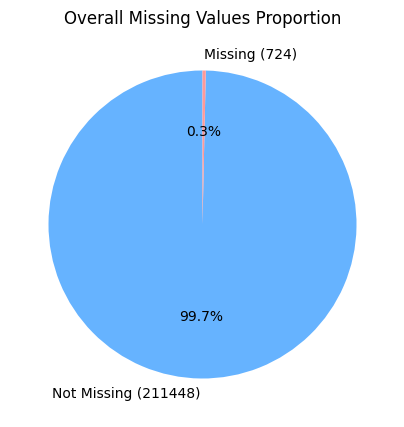

In [7]:
missing = df.isnull().sum().sum()
not_missing = df.size - missing

plt.figure(figsize=(5, 5))
plt.pie([not_missing, missing],
        labels=[f'Not Missing ({not_missing})', f'Missing ({missing})'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff', '#ff9999'])
plt.title('Overall Missing Values Proportion')
plt.show()

### EDA Findings & Cleaning Strategy
* **Imbalance**: The label distribution shows that *normal* and *depression*-related statements dominate, while *stress* and *presonality disorder* classes are rare. We'll need to make sure we account for that in our training.
* **Outliers**: Statements that exceed 10,000 characters are rare, and as such these may bias training. We'll remove them, as well as unreasonably short statements (3 characters won't say anything of value in this context).
* **Missing values**: No row is missing the status, and a few are missing the statement itself. Given the nature of this data, imputing anything as the statement might prove problematic. Given the small number of rows we'll lose here, I'll just let them drop as part of the outliers (length 0).
* **Data Standardisation**: We'll remove things like URLs, punctuation, etc. These won't hold significant predictive value and may make our data much noisier.

In [8]:
df['statement'] = df['statement'].astype('category')
df['status'] = df['status'].astype('category')

rows_before_cleaning = len(df)
cleaning_steps_summary = {}

df = df[df['statement'].str.len().between(3, 10000)]
rows_after_length = len(df)
cleaning_steps_summary['Length Outliers'] = rows_before_cleaning - rows_after_length

df = df.drop_duplicates(subset='statement')
rows_after_duplicates = len(df)
cleaning_steps_summary['Duplicate Statements'] = rows_after_length - rows_after_duplicates

rows_after_cleaning = len(df)

summary_df = pd.DataFrame(list(cleaning_steps_summary.items()), columns=['Cleaning Step', 'Rows Dropped'])
display(summary_df)

print(f"Rows before cleaning: {rows_before_cleaning} -> after: {rows_after_cleaning}")
print(f"Total rows dropped: {rows_before_cleaning - rows_after_cleaning}\n")

,Cleaning Step,Rows Dropped
0,Length Outliers,382
1,Duplicate Statements,1608


Rows before cleaning: 53043 -> after: 51053
Total rows dropped: 1990



In [9]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text, flags=re.UNICODE)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text.lower().strip()
    
df['statement'] = df['statement'].astype(str).apply(clean_text)

### N-Grams
N-Grams is a technique that will let us see common association. With our clean data we'll produce a grid, with each row corresponding to a sentiment like "Depression," "Anxiety," etc.

* The first column will show the most common single words (unigrams), giving you a quick look at the core vocabulary.
* The second column will show the most common two-word phrases (bigrams), which often reveal more context (e.g., "feel like," "social anxiety").
* The third column will show the most common three-word phrases (trigrams), which can highlight specific recurring themes or expressions (e.g., "don't want to," "feel like I'm").

This can help us better understand patterns in the data.

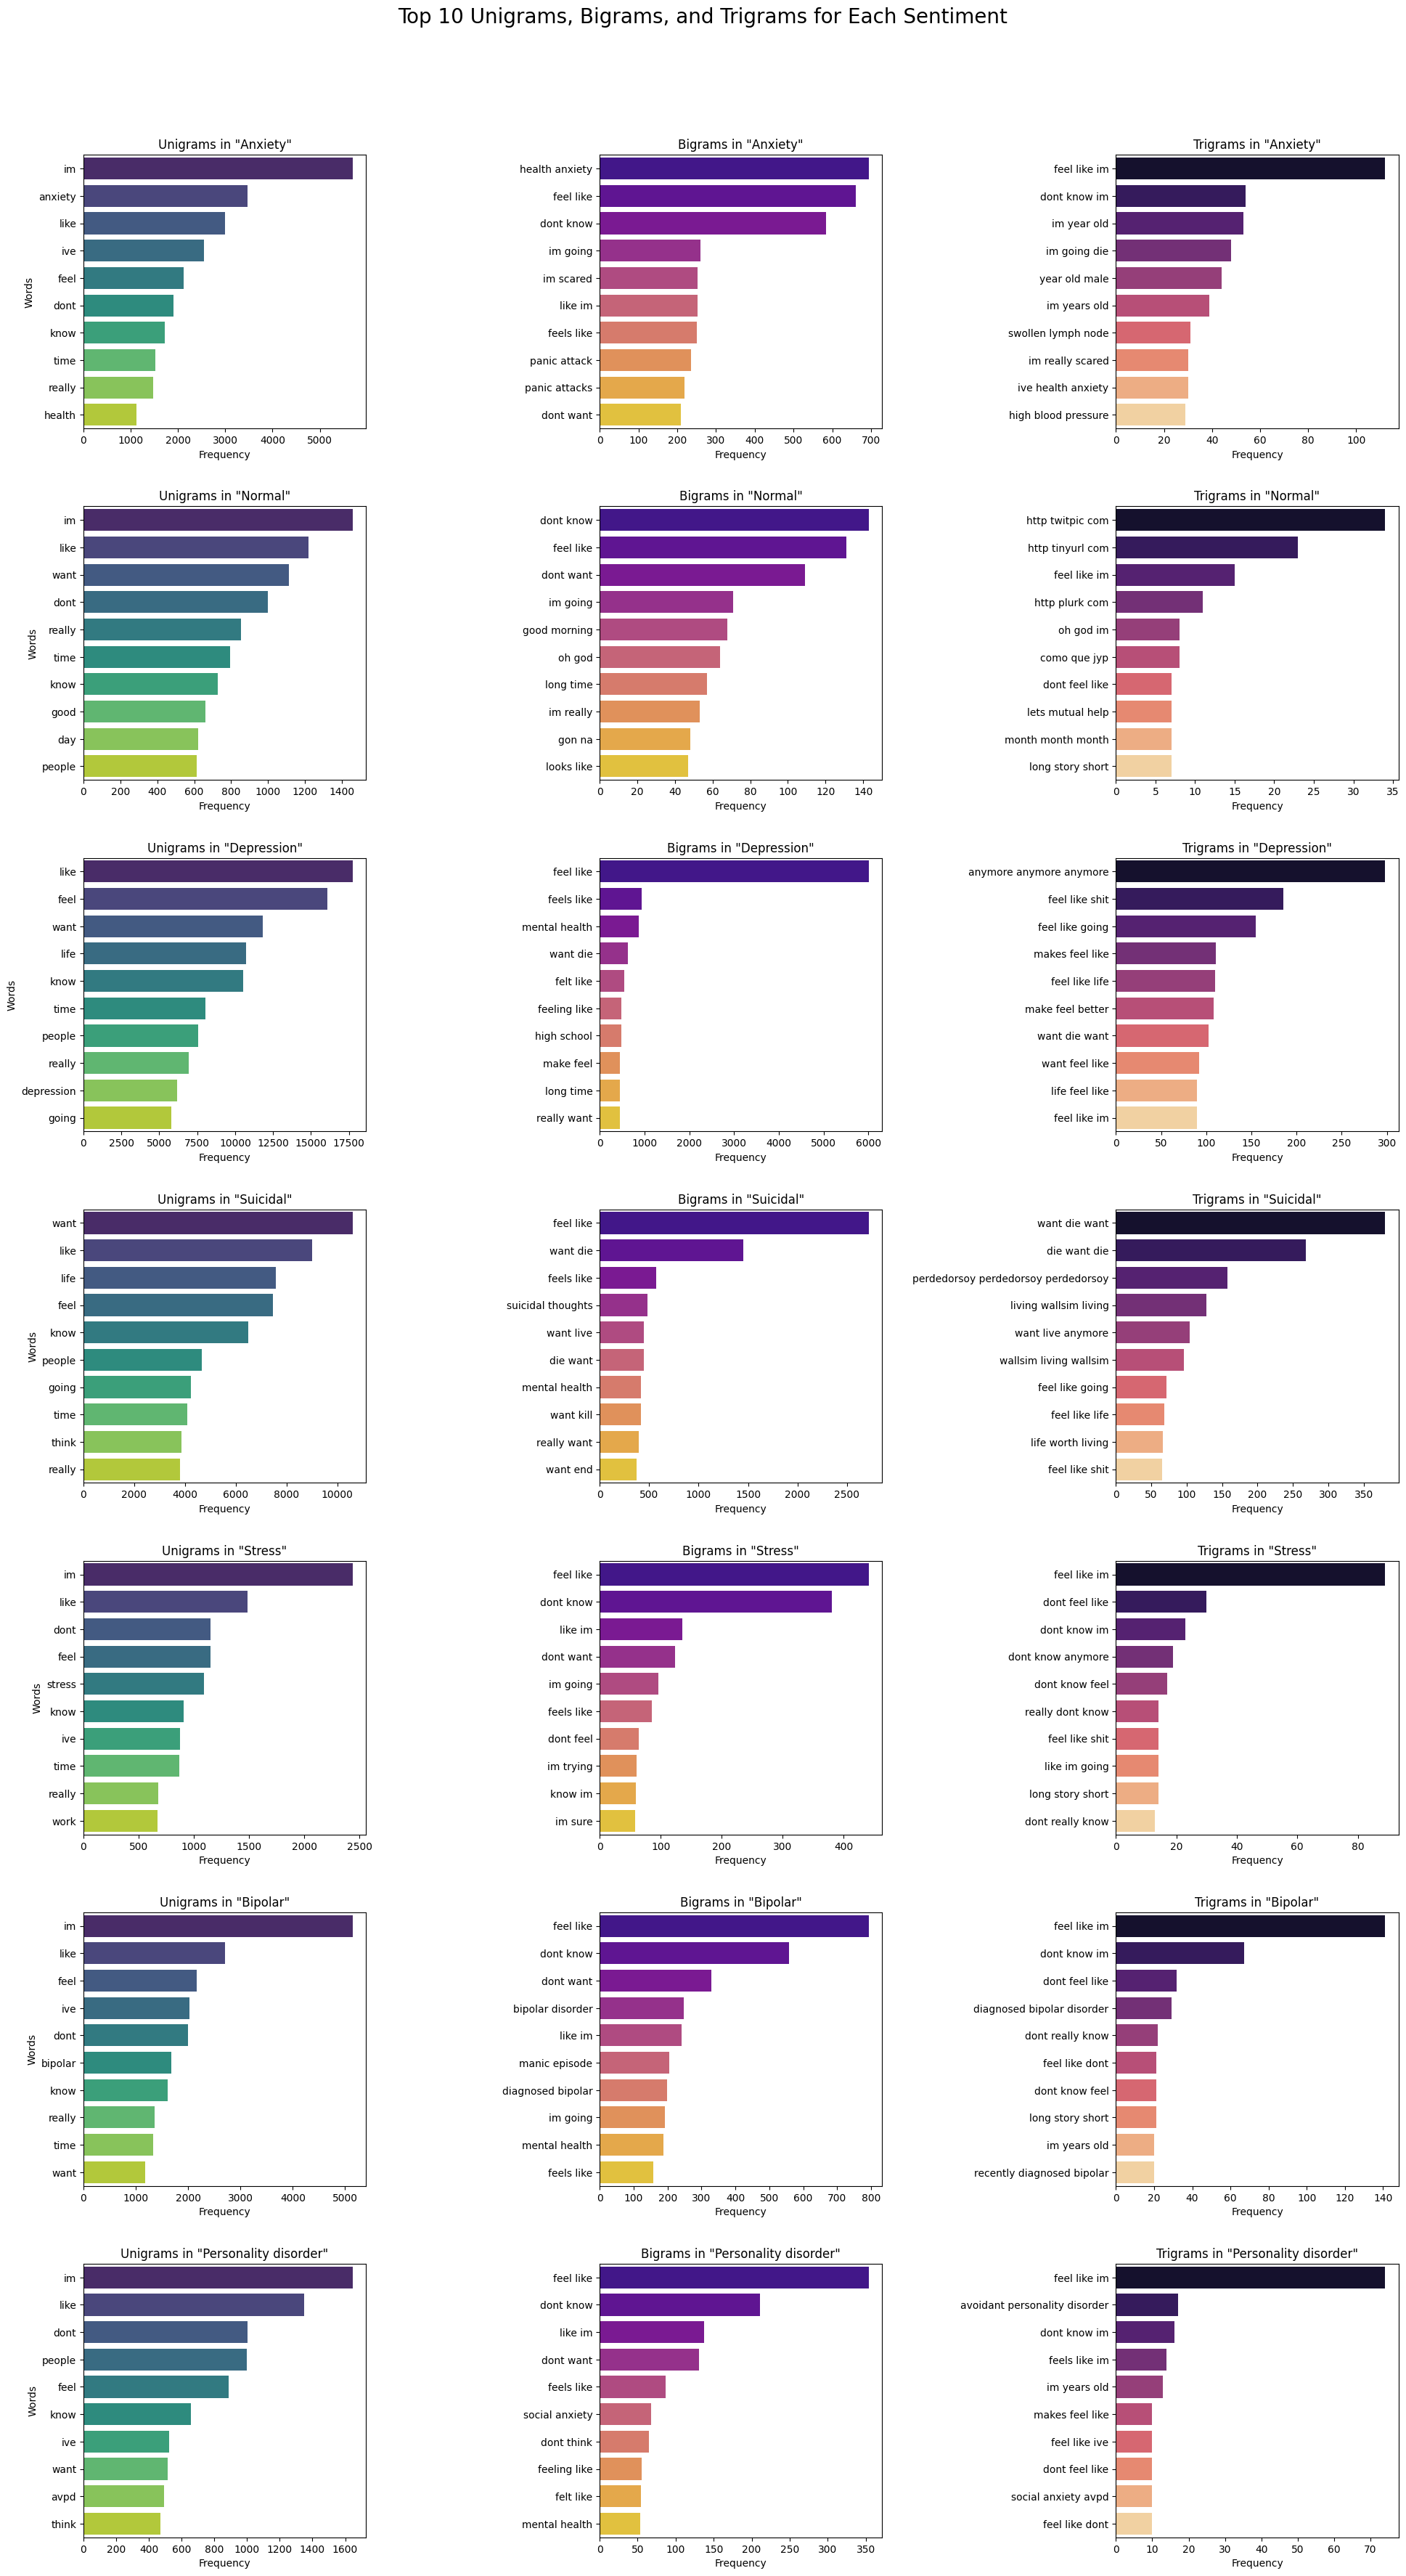

In [10]:
def get_top_n_grams(corpus, n_grams, n=10):
    vec = CountVectorizer(ngram_range=(n_grams, n_grams), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

labels = df['status'].unique()

fig, axes = plt.subplots(len(labels), 3, figsize=(20, len(labels) * 5))
fig.suptitle('Top 10 Unigrams, Bigrams, and Trigrams for Each Sentiment', fontsize=20, y=1.02)

for i, label in enumerate(labels):
    text = df[df['status'] == label]['statement']

    top_unigrams = get_top_n_grams(text, n_grams=1, n=10)
    x_uni, y_uni = map(list, zip(*top_unigrams))
    sns.barplot(x=y_uni, y=x_uni, ax=axes[i, 0], palette='viridis')
    axes[i, 0].set_title(f'Unigrams in "{label}"')
    axes[i, 0].set_xlabel('Frequency')
    axes[i, 0].set_ylabel('Words')

    top_bigrams = get_top_n_grams(text, n_grams=2, n=10)
    x_bi, y_bi = map(list, zip(*top_bigrams))
    sns.barplot(x=y_bi, y=x_bi, ax=axes[i, 1], palette='plasma')
    axes[i, 1].set_title(f'Bigrams in "{label}"')
    axes[i, 1].set_xlabel('Frequency')
    axes[i, 1].set_ylabel('') 

    top_trigrams = get_top_n_grams(text, n_grams=3, n=10)
    x_tri, y_tri = map(list, zip(*top_trigrams))
    sns.barplot(x=y_tri, y=x_tri, ax=axes[i, 2], palette='magma')
    axes[i, 2].set_title(f'Trigrams in "{label}"')
    axes[i, 2].set_xlabel('Frequency')
    axes[i, 2].set_ylabel('')

plt.tight_layout(pad=3.0)
plt.show()

As we can see, even after cleaning our data it's still far from perfect and contains things like non-words which might be far from ideal.
This is sufficient for our needs in this project, but can be considered for future improvements. We can also see overlap in top n-grams between the different classes, which might make it difficult for the model to learn meaningful differentiators.

## 3.  Modelling
We compare two approaches:
1. **Baseline**: TF‑IDF features + Multinomial Logistic Regression. This is a good baseline model, which converts a collection of text documents into a matrix of numerical features and then performs classic logistic regression on those features to create predictions.
2. **Deep Learning**:  GRU (Gated Recurrent Unit) Network. Like its older sibling the LSTM, GRUs are a type of Recurrent Neural Network (RNN) designed to handle sequential data like text. They use a gating mechanism to manage and control the flow of information, allowing them to capture context from earlier parts of a sequence. This is crucial for understanding the full narrative of a user's statement about their mental health, and can lead to more sophisticated models. Additionally, its architecture is simpler and more efficient than LSTMs, letting us use fewer parameters which is less prone to overfitting. This is exteremly important given our small dataset.

### 3.1. Baseline

In [11]:
# Encode labels to integers
encoder = LabelEncoder()
labels = encoder.fit_transform(df['status'])

training_sentences, testing_sentences, training_labels_int, testing_labels_int = train_test_split(
    df['statement'], labels, test_size=0.2, random_state=42
)

# One-hot encode for Keras
num_classes = len(encoder.classes_)
training_labels = to_categorical(training_labels_int, num_classes=num_classes)
testing_labels = to_categorical(testing_labels_int, num_classes=num_classes)

print(len(training_sentences), len(testing_sentences))

40842 10211


In [12]:
baseline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1, multi_class='multinomial'))
])

baseline.fit(training_sentences, training_labels_int)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='multinomial', n_jobs=-1))])

### 3.2. GRU
#### Data Preparation

Before we build the GRU Model, we need to prepare the data in a format that the model can understand. This involves:
* **Encoding Labels**: Converting the categorical text labels into numerical format.
* **Tokenizing Text**: Converting the text into sequences of integers.
* **Padding Sequences**: Ensuring that all text sequences have the same length.

In [13]:
vocab_size = 10000
embedding_dim = 128
statement_lengths = df['statement'].apply(lambda x: len(x.split()))
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(training_labels_int),
    y=training_labels_int
)
class_weights_dict = dict(enumerate(class_weights))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(
    training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

### Model definition
We'll allow to flexibly set the hyperparameters of the model to make it easier to tune them

In [14]:
def build_model(hp):
    model = Sequential()
    
    hp_embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=128, step=32)
    model.add(Embedding(vocab_size, hp_embedding_dim, input_length=max_length))
    
    hp_gru_units = hp.Int('gru_units', min_value=32, max_value=64, step=16)
    hp_l2 = hp.Choice('l2_rate', values=[1e-2, 1e-3, 1e-4])
    model.add(Bidirectional(GRU(hp_gru_units, kernel_regularizer=regularizers.l2(hp_l2))))
    
    hp_dropout = hp.Float('dropout', min_value=0.4, max_value=0.6, step=0.1)
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Hyperparameter tuning
Before training our full model, we'll use the Keras tuner to test a few possible settings. These will be trained for a shorter time to evaluate how they perform for our data.

In [15]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='models_dir',
    project_name='mental_health_models',
    seed=SEED
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

tuner.search(
    training_padded,
    training_labels,
    epochs=10,
    validation_data=(testing_padded, testing_labels),
    class_weight=class_weights_dict,
    callbacks=[stop_early]
)

Trial 10 Complete [00h 03m 08s]
val_accuracy: 0.7145235538482666

Best val_accuracy So Far: 0.7507590055465698
Total elapsed time: 00h 34m 03s


### Full training

In [16]:
tuner.results_summary()

# Get the model that performed best so far
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

Results summary
Results in models_dir/mental_health_models
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
embedding_dim: 128
gru_units: 32
l2_rate: 0.0001
dropout: 0.4
Score: 0.7507590055465698

Trial 03 summary
Hyperparameters:
embedding_dim: 128
gru_units: 48
l2_rate: 0.001
dropout: 0.4
Score: 0.7323474884033203

Trial 04 summary
Hyperparameters:
embedding_dim: 64
gru_units: 32
l2_rate: 0.0001
dropout: 0.5
Score: 0.7253941893577576

Trial 09 summary
Hyperparameters:
embedding_dim: 128
gru_units: 48
l2_rate: 0.001
dropout: 0.5
Score: 0.7145235538482666

Trial 02 summary
Hyperparameters:
embedding_dim: 96
gru_units: 32
l2_rate: 0.001
dropout: 0.4
Score: 0.7140339016914368

Trial 06 summary
Hyperparameters:
embedding_dim: 96
gru_units: 32
l2_rate: 0.01
dropout: 0.4
Score: 0.6947409510612488

Trial 07 summary
Hyperparameters:
embedding_dim: 32
gru_units: 32
l2_rate: 0.0001
dropout: 0.5
Score: 0.6886690855026245

Trial 00 summary


In [17]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the best model for longer
history = best_model.fit(
    training_padded,
    training_labels,
    epochs=20,
    validation_data=(testing_padded, testing_labels),
    class_weight=class_weights_dict,
    callbacks=[stop_early, lr_scheduler]
)

Epoch 1/20


2025-06-13 15:51:10.003565: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4799 - loss: 1.5549

2025-06-13 15:51:43.703624: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1277/1277 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.4800 - loss: 1.5547 - val_accuracy: 0.6837 - val_loss: 0.8198 - learning_rate: 0.0010
Epoch 2/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6908 - loss: 0.8061 - val_accuracy: 0.7133 - val_loss: 0.7454 - learning_rate: 0.0010
Epoch 3/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.7472 - loss: 0.5928 - val_accuracy: 0.7218 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 4/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.7827 - loss: 0.4716 - val_accuracy: 0.7354 - val_loss: 0.7454 - learning_rate: 0.0010
Epoch 5/20
1275/1277 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8056 - loss: 0.3877
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8056 - loss: 0.3877 - val_accuracy: 0.7347 - val_loss: 0.7952 - learning_rate: 0.0010
Epoch 6/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8316 -

2025-06-13 15:54:27.561987: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Test Accuracy: 72.18%


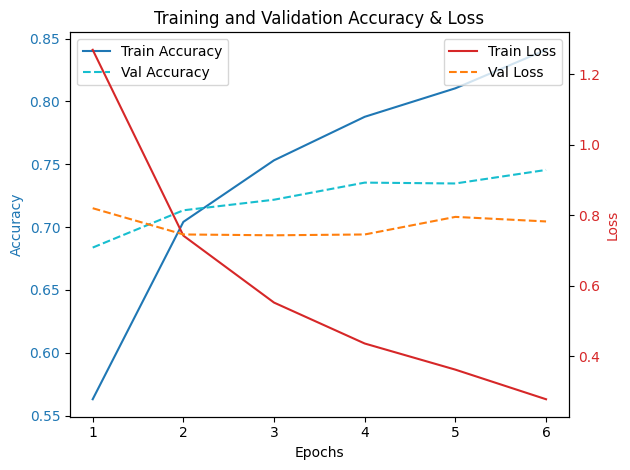

In [18]:
loss, accuracy = best_model.evaluate(testing_padded, testing_labels, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')

epochs = range(1, len(history.history['loss']) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(epochs, acc, label='Train Accuracy', color=color)
ax1.plot(epochs, val_acc, label='Val Accuracy', color='tab:cyan', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(epochs, loss, label='Train Loss', color=color)
ax2.plot(epochs, val_loss, label='Val Loss', color='tab:orange', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Training and Validation Accuracy & Loss')
fig.tight_layout()
plt.show()

## 4. Results and Analysis
After training both models, we will evaluate their performance on the test set using a variety of metrics. Our training ended early due to the valuation accuracy drifting, and as we can see from the training chart above the model diverged from  
Given the class imbalance observed during the EDA, accuracy alone is not a sufficient metric. We will therefore use the following:

* Accuracy: The overall percentage of correctly classified instances.
* Precision, Recall, and F1-Score (per class): These metrics provide a more detailed understanding of the model's performance on each individual sentiment class.
* Confusion Matrix: A visualization that shows the number of correct and incorrect predictions for each class. This is particularly useful for identifying which classes the model is struggling to distinguish between.
* Classification Report: A summary of the precision, recall, and F1-score for each class.

In [19]:
y_pred_baseline = baseline.predict(testing_sentences)
y_pred_gru_prob = best_model.predict(testing_padded, verbose=0)
y_pred_gru      = y_pred_gru_prob.argmax(axis=1)

In [20]:
precision_base, recall_base, f1_base, _ = precision_recall_fscore_support(
    testing_labels_int, y_pred_baseline, average='weighted'
)

precision_gru, recall_gru, f1_gru, _ = precision_recall_fscore_support(
    testing_labels_int, y_pred_gru, average='weighted'
)

metrics = pd.DataFrame({
    "Model":     ["Baseline LR", "Best GRU"],
    "Accuracy":  [accuracy_score(testing_labels_int, y_pred_baseline),
                  accuracy_score(testing_labels_int, y_pred_gru)],
    "Precision": [precision_base, precision_gru],
    "Recall":    [recall_base, recall_gru],
    "F1-Score":  [f1_base, f1_gru]
})

display(metrics.style.format({
    "Accuracy": "{:.3%}",
    "Precision": "{:.3%}",
    "Recall": "{:.3%}",
    "F1-Score": "{:.3%}"
}))

,Model,Accuracy,Precision,Recall,F1-Score
0,Baseline LR,74.616%,75.879%,74.616%,74.743%
1,Best GRU,72.177%,75.085%,72.177%,72.220%


As we can see, for broad metrics our GRU Model roughly on-par with the baseline across the board.
However, we might also want to go deeper into the performance of each model and see how they perform on each category.

Baseline – Logistic Regression

                      precision    recall  f1-score   support

             Anxiety       0.74      0.82      0.78       695
             Bipolar       0.75      0.78      0.76       520
          Depression       0.79      0.61      0.69      3048
              Normal       0.88      0.89      0.88      3224
Personality disorder       0.44      0.63      0.52       191
              Stress       0.46      0.63      0.53       468
            Suicidal       0.64      0.72      0.68      2065

            accuracy                           0.75     10211
           macro avg       0.67      0.73      0.69     10211
        weighted avg       0.76      0.75      0.75     10211



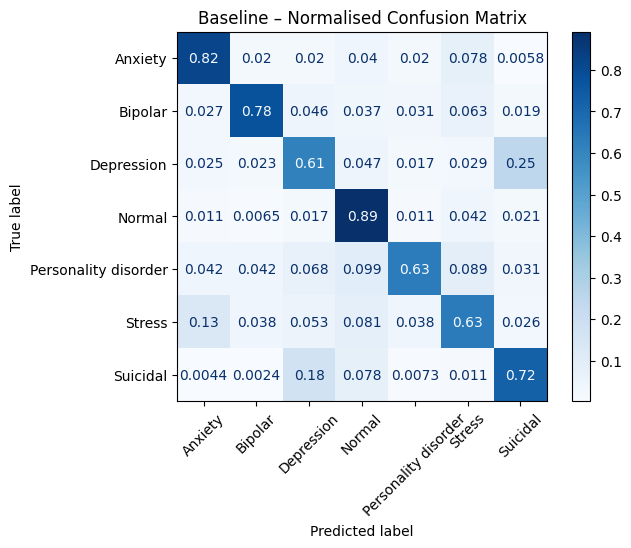


Best GRU Model

                      precision    recall  f1-score   support

             Anxiety       0.75      0.83      0.79       695
             Bipolar       0.67      0.84      0.75       520
          Depression       0.77      0.49      0.60      3048
              Normal       0.92      0.89      0.91      3224
Personality disorder       0.38      0.68      0.49       191
              Stress       0.44      0.67      0.53       468
            Suicidal       0.57      0.74      0.64      2065

            accuracy                           0.72     10211
           macro avg       0.64      0.74      0.67     10211
        weighted avg       0.75      0.72      0.72     10211



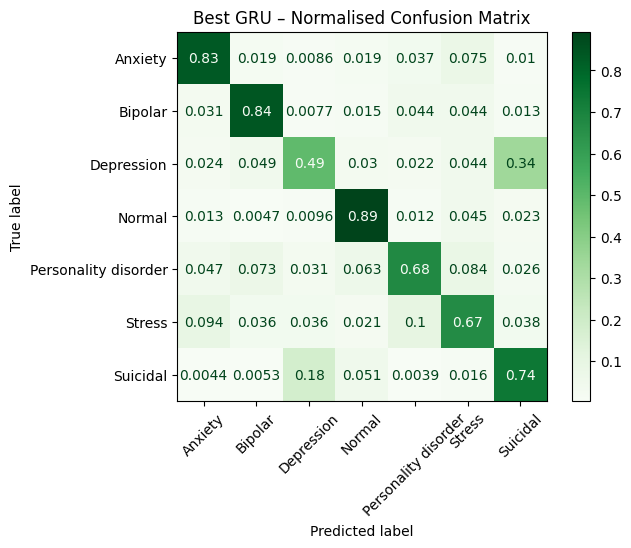

In [21]:
print("Baseline – Logistic Regression\n")
print(classification_report(testing_labels_int,
                            y_pred_baseline,
                            target_names=encoder.classes_))

cm_base = confusion_matrix(testing_labels_int,
                           y_pred_baseline,
                           normalize="true")

ConfusionMatrixDisplay(cm_base,
                       display_labels=encoder.classes_).plot(
                           xticks_rotation=45, cmap="Blues")
plt.title("Baseline – Normalised Confusion Matrix")
plt.show()

print("\nBest GRU Model\n")
print(classification_report(testing_labels_int,
                            y_pred_gru,
                            target_names=encoder.classes_))

cm_gru = confusion_matrix(testing_labels_int,
                           y_pred_gru,
                           normalize="true")

ConfusionMatrixDisplay(cm_gru,
                       display_labels=encoder.classes_).plot(
                           xticks_rotation=45, cmap="Greens")
plt.title("Best GRU – Normalised Confusion Matrix")
plt.show()

As we can see when looking deeper into those results, the GRU model also performs roughly the same as the baseline across every category. Given the models converged to such similar scores, it might be reasonable to believe this is the most that can be extracted meaningfully from the dataset.

## 5. Discussion and Conclusion
### 5.1. Summary of Findings

This project demonstrated an application of Deep Learning for mental health sentiment analysis. It showed Deep Learning methods like GRU may not overperform traditional supervised learning techniques like Linear Regression in producing more accurate predictions even in NLP context when our dataset is insufficient. Overfitting is a real concern in those contexts and is very hard to avoid.

### 5.2. Challenges and Limitations

* One significant challenge is the class imbalance in the dataset. While we took steps to mitigate this, it can still impact the model's performance on minority classes.
* Deep Learning algorithms can be computationally expensive to train and iterate on compared to their traditional counterparts. It took the GRU model significantly longer training time to reach pairity with the Linear Regression model's performance.

### 5.3. Future Work and Improvements

* Addressing Class Imbalance: More advanced techniques for handling class imbalance could be explored, such as using focal loss during training.
* Ensemble Models: Combining the predictions of GRU with other models (e.g. BERT) could potentially lead to better performance.